In [42]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import roc_auc_score
import numpy as np
import math
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from roc_helper import plot_roc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.optimizers import Adam

In [1]:
# disclaimer: all PLOTTING functions/code are not written by me (but by AI), I hope thats alright (if not, let me know and we can work something out!)
# everything else, unless said otherwise, is written by me (or copied from the hands-on tutorials / homework notebooks from Duarte)

# Problem 2, Parts A-B: Boosted Decision Tree

In this Jupyter notebook, we will train a boosted decision tree on the MiniBooNE dataset.

Use this notebook to write your code for problem 1 parts A-B by filling in the sections marked `# TODO` and running all cells.

In [3]:
# copied from plotting.py but added ylims for this notebook
def plot_model_history(history):
    """Plot the training and validation history for a TensorFlow network"""

    # Extract loss and accuracy
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    n_epochs = len(loss)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].plot(np.arange(n_epochs), loss, label="Training")
    ax[0].plot(np.arange(n_epochs), val_loss, label="Validation")
    ax[0].set_ylim(0, 0.5)
    ax[0].legend()
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")

    ax[1].plot(np.arange(n_epochs), acc, label="Training")
    ax[1].plot(np.arange(n_epochs), val_acc, label="Validation")
    ax[1].set_ylim(.7, 1)
    ax[1].legend()
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")

In [4]:
data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# filter out rows containing the -999 sentinel in ANY feature
train_mask = (X_train != -999).all(axis=1)
test_mask = (X_test != -999).all(axis=1)

X_train_filtered = X_train[train_mask]
X_test_filtered = X_test[test_mask]
y_train_filtered = y_train[train_mask]
y_test_filtered = y_test[test_mask]

# print the new dimensions of the filtered datasets
print("X_train_filtered shape: ", X_train_filtered.shape[0] / X_train.shape[0])
print("y_train_filtered shape: ", y_train_filtered.shape[0] / y_train.shape[0])
print("X_test_filtered shape: ", X_test_filtered.shape[0] / X_test.shape[0])
print("y_test_filtered shape: ", y_test_filtered.shape[0] / y_test.shape[0])

X_train_filtered shape:  0.9963863874446185
y_train_filtered shape:  0.9963863874446185
X_test_filtered shape:  0.9964633068081344
y_test_filtered shape:  0.9964633068081344


In [5]:
def plot_feature_distributions(X_data, y_labels, feature_names, ncols=4, figsize_per_col=5, figsize_per_row=3.5, n_bins=100, title_fontsize=10, tick_fontsize=8, legend_fontsize=8):
    
    y_arr = np.asarray(y_labels)

    signal_mask = y_arr == 1
    background_mask = y_arr == 0
    
    n_features = X_data.shape[1]
    nrows = math.ceil(n_features / ncols)
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize_per_col * ncols, figsize_per_row * nrows))
    axs = np.array(axs).reshape(-1)
    
    for i in range(n_features):
        ax = axs[i]
        signal_vals = X_data[signal_mask, i]
        background_vals = X_data[background_mask, i]
        
        xmin = min(signal_vals.min(), background_vals.min())
        xmax = max(signal_vals.max(), background_vals.max())
        bins = np.linspace(xmin, xmax, n_bins)
        
        ax.hist(background_vals, bins=bins, alpha=0.5, density=True, label="background")
        ax.hist(signal_vals, bins=bins, alpha=0.5, density=True, label="signal")
        ax.set_title(feature_names[i], fontsize=title_fontsize)
        ax.tick_params(axis="both", labelsize=tick_fontsize)
    
    # Hide any unused subplot axes
    for i in range(n_features, len(axs)):
        axs[i].axis("off")
    
    axs[0].legend(fontsize=legend_fontsize)
    plt.tight_layout()
    
    return fig

Let's analyze what we are working with

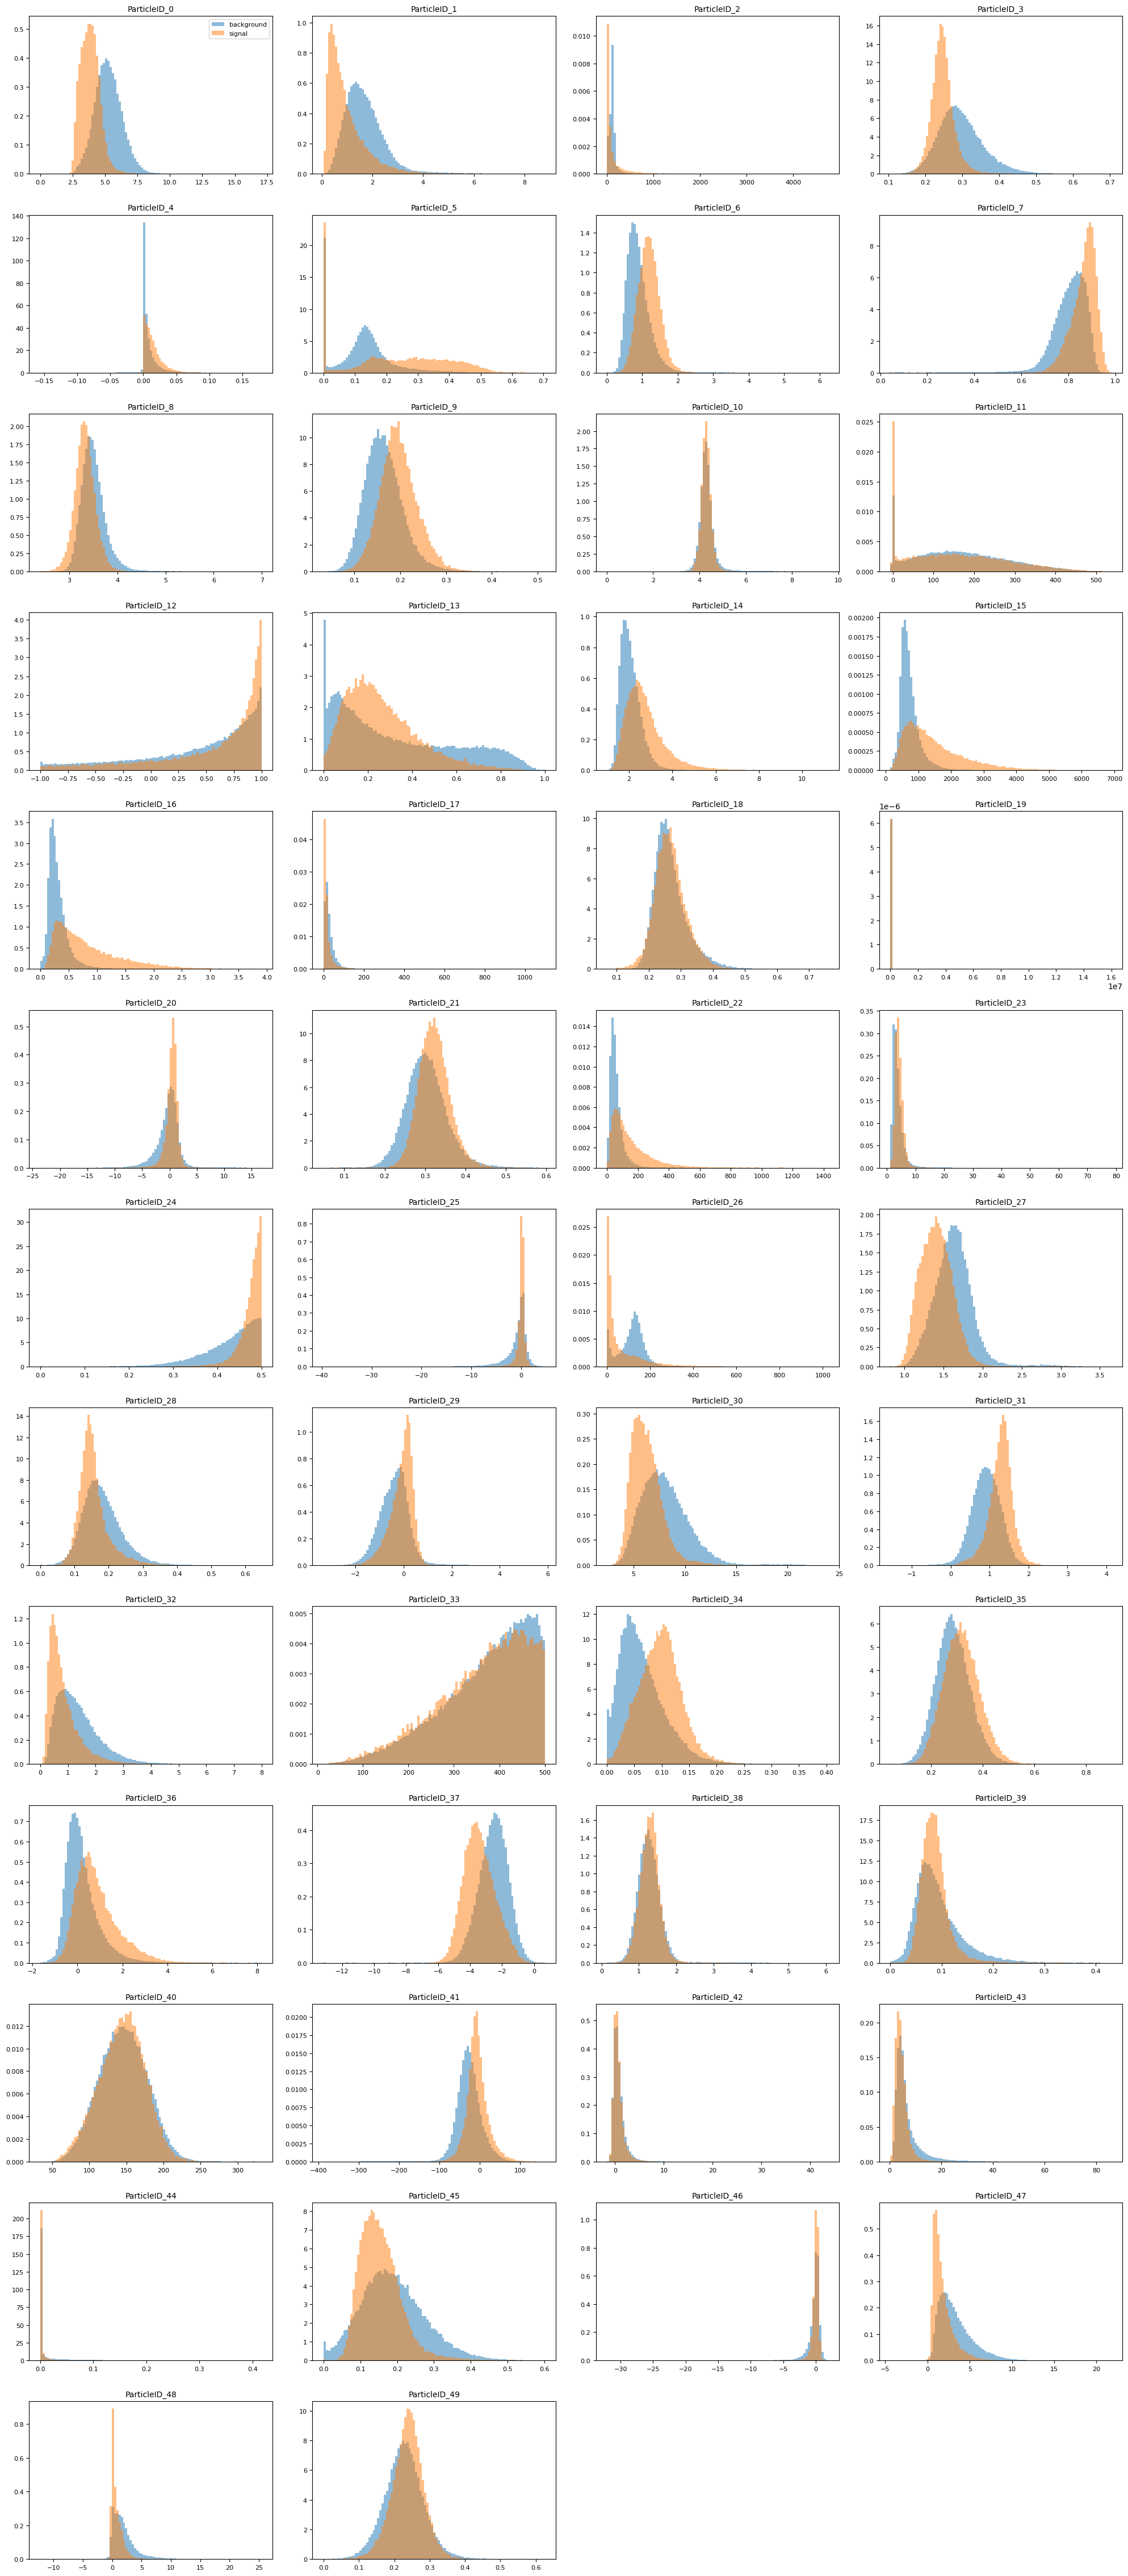

In [6]:
feature_names = data.feature_names
fig = plot_feature_distributions(X_train_filtered, y_train_filtered, feature_names)
plt.show()

We see we will have to manipulate these features, to get a good result in the end. Almost nothing is centered around 0 yet, and the standard deviation is quite big for some. This will be fixed when we scale the data. Also we have some features with extremely long tails or outliers. This will be fixed in the last part with further refinements.

Let's check that we did things correctly and analyze a bit further

In [7]:
# sanity checks after filtering
for feature_idx in range(X_train_filtered.shape[1]):
	if feature_idx <10 or feature_idx >40:
		train_min = np.min(X_train_filtered[:, feature_idx])
		train_max = np.max(X_train_filtered[:, feature_idx])
		test_min = np.min(X_train_filtered[:, feature_idx])
		test_max = np.max(X_train_filtered[:, feature_idx])
		print(
			f"Feature {feature_idx:2d} | "
			f"train_scaled[min,max]=({train_min:.6g}, {train_max:.6g}) | "
			f"test_scaled[min,max]=({test_min:.6g}, {test_max:.6g})"
		)

Feature  0 | train_scaled[min,max]=(0, 17.0573) | test_scaled[min,max]=(0, 17.0573)
Feature  1 | train_scaled[min,max]=(0.0707482, 8.80282) | test_scaled[min,max]=(0.0707482, 8.80282)
Feature  2 | train_scaled[min,max]=(0.0123806, 4747.67) | test_scaled[min,max]=(0.0123806, 4747.67)
Feature  3 | train_scaled[min,max]=(0.104697, 0.704169) | test_scaled[min,max]=(0.104697, 0.704169)
Feature  4 | train_scaled[min,max]=(-0.156118, 0.179012) | test_scaled[min,max]=(-0.156118, 0.179012)
Feature  5 | train_scaled[min,max]=(0, 0.703859) | test_scaled[min,max]=(0, 0.703859)
Feature  6 | train_scaled[min,max]=(0, 6.24108) | test_scaled[min,max]=(0, 6.24108)
Feature  7 | train_scaled[min,max]=(0.041932, 0.982981) | test_scaled[min,max]=(0.041932, 0.982981)
Feature  8 | train_scaled[min,max]=(2.39744, 6.99229) | test_scaled[min,max]=(2.39744, 6.99229)
Feature  9 | train_scaled[min,max]=(0.033432, 0.515115) | test_scaled[min,max]=(0.033432, 0.515115)
Feature 41 | train_scaled[min,max]=(-387.617, 16

In [8]:
# ! pip install xgboost

In [ ]:
# help(XGBClassifier)

## Problem 1A

Using the MiniBooNE dataset and XGBoost, train a boosted decision tree on the
training dataet. Use the Scikit-learn API xgboost.XGBClassifier. For an initial choice of hyperparam-
eters use 100 trees (n_estimators), maximum tree depth (max_depth) of 10, learning rate (learning_-
rate) of 0.1, colsample_bytree of 0.8, and subsample of 0.8.

In [10]:
bdt = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, colsample_bytree=0.8, subsample=0.8)

bdt.fit(X_train_filtered, y_train_filtered)

# retrieve predictions and take index [:, 1] corresponding to signal
preds_bdt = bdt.predict_proba(X_test_filtered)[:, 1]

Plot the receiver operating characteristic (ROC) curve using the testing dataset. What area under the curve
(AUC) and accuracy do you achieve “out of the box”?

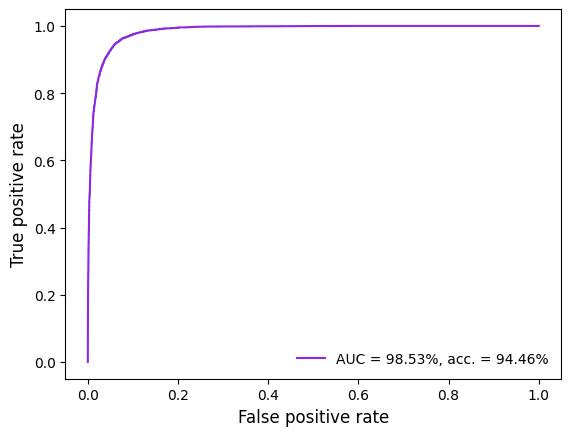

In [47]:
roc_bdt = plot_roc(y_test_filtered, preds_bdt)

## Problem B

Plot the F -score for all the 10 “most important” features using xgboost.plot_-
importance. Which feature is the most important?

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

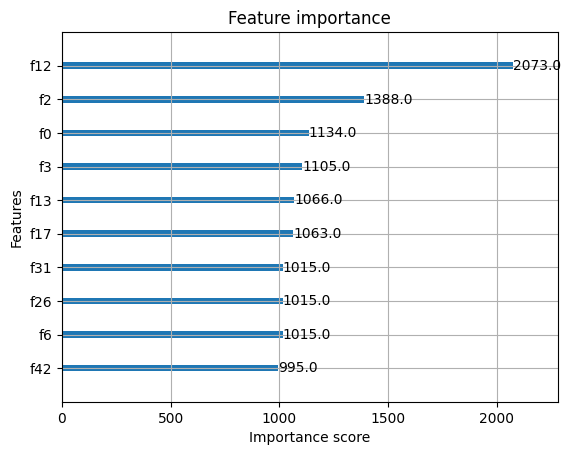

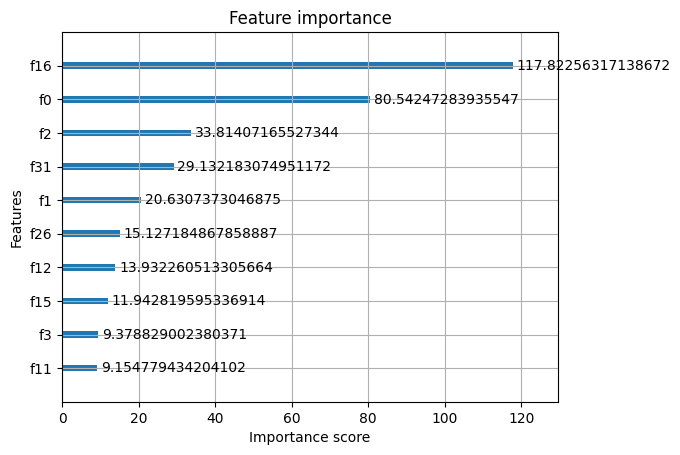

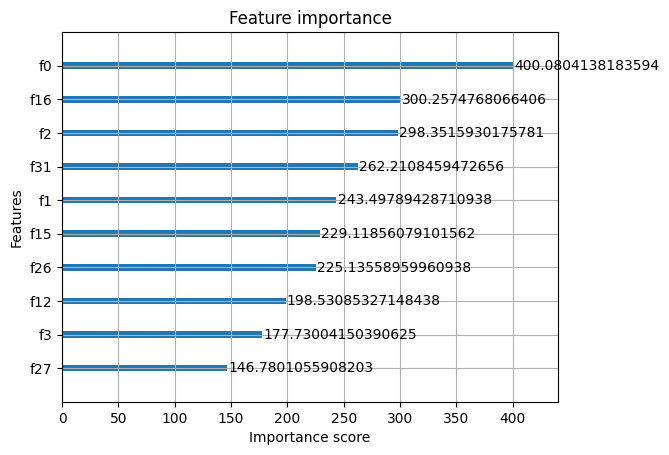

In [38]:
xgb.plot_importance(bdt, max_num_features=10, importance_type="weight")
xgb.plot_importance(bdt, max_num_features=10, importance_type="gain")
xgb.plot_importance(bdt, max_num_features=10, importance_type="cover")

In short: weight = frequency, gain = usefulness per use, cover = how many datapoints it touches.

We see Feature index 12 has the highest importance score here by weight.

With a different metric we see feature 16 is the most important based on gain.

With a different metric we see feature 0 is the most important based on cover.

Plot this feature using the testing dataset in a 1D histogram separately for signal and background. For the
histogram binning, use 100 bins from the minimum value of this feature to the maximum value of this
feature in the testing dataset. What do you notice about this feature?

In [26]:
def plot_most_imp_feature(X_test, feature_idx):
    feat_vals = X_test[:, feature_idx]

    xmin = np.nanmin(feat_vals)
    xmax = np.nanmax(feat_vals)

    signal_vals = X_test[y_test_filtered == 1, feature_idx]
    background_values = X_test[y_test_filtered == 0, feature_idx]

    print("feature min, max:", xmin, xmax)
    print("unique values count:", len(np.unique(feat_vals)))

    # Create 100 bins between min and max (101 edges)
    bins = 100

    plt.hist(background_values, bins=bins, alpha=0.5, label="Background")
    plt.hist(signal_vals, bins=bins, alpha=0.5, label="Signal")
    plt.xlabel("Most Important Feature")
    plt.ylabel("Count")
    plt.title("Distribution of the Most Important Feature")
    plt.legend()
    plt.show()

feature min, max: -0.999999 1.0
unique values count: 25575


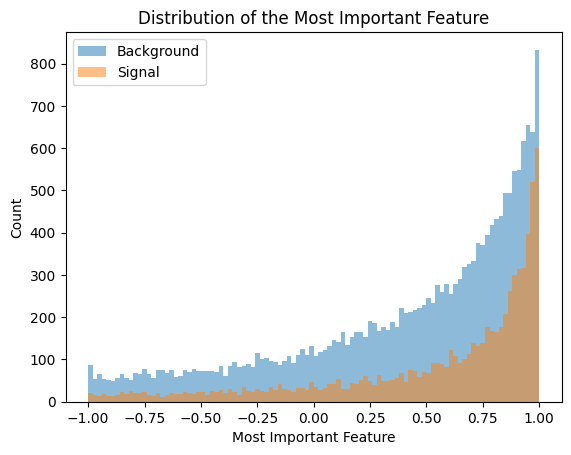

feature min, max: 0.00378816 3.74218
unique values count: 25396


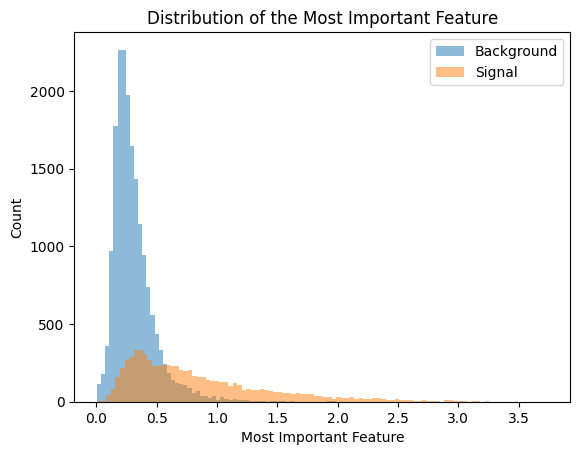

feature min, max: 0.0 16.0604
unique values count: 25085


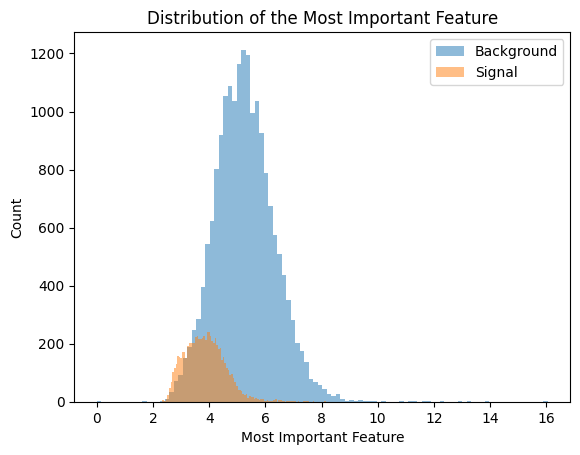

In [39]:
plot_most_imp_feature(X_test_filtered, 12)
plot_most_imp_feature(X_test_filtered, 16)
plot_most_imp_feature(X_test_filtered, 0)

For feature 12, the distribution is not very unique or differentiating signal compared to background.
This would not be a good classifier.
But it is used with other features a lot probably, correlated perhaps.
Would work well with a NN model 'out of the box' because it has values centered around 0 and goes from -1 to +1, but that would only give an advantage with NNs not with a BDT here.

In comparison, feature 16 is a strong discriminator because the signal distribution is shifted to larger values than background and is much wider / longer tail.
There is still overlap around the central region, so it’s useful but not perfectly separable alone.
The signal's heavy tail and positive skew suggest potential benefit from scaling or a transform before using in a neural net.

Again for feature, 0 we see a good classifier, although they do overlap completely, which is probably why feature 16 outperforms.

Lets see how well it performs with just these features:

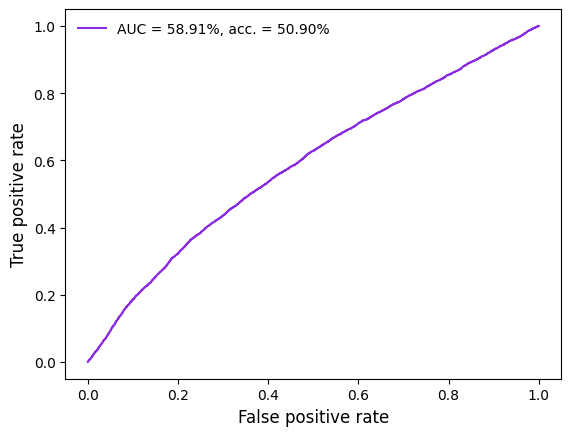

In [48]:
feat = X_test_filtered[:, 12]
plot_roc(y_test_filtered, feat)
plt.close()

Very bad! almost 50-50, guessing. Which makes sense based on our assesment before.

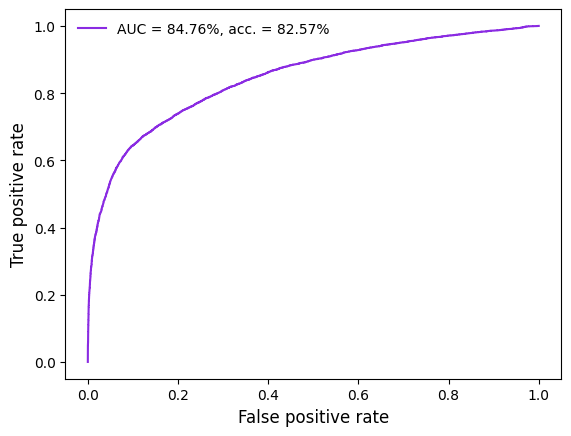

In [49]:
feat = X_test_filtered[:, 16]
plot_roc(y_test_filtered, feat)
plt.close()

Already very good! If you're short on computational power, time or lazy: just use this feature and call it a day.

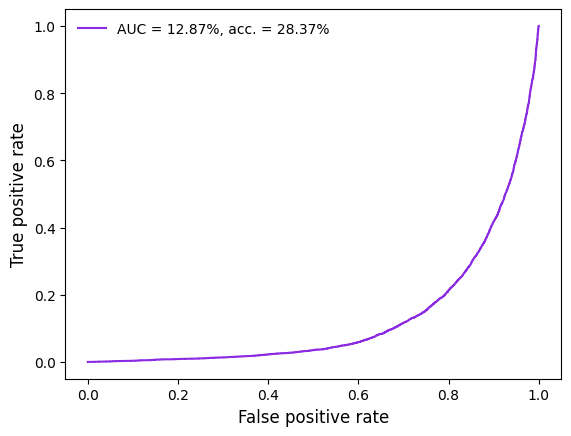

In [50]:
feat = X_test_filtered[:, 0]
plot_roc(y_test_filtered, feat)
plt.close()

The opposite of very good! But this means something is going wrong, and does not necessarily means it is a bad feature (paraphrasing you/Felix here).

# Problem 2, Parts C-E: Neural Network

In this Jupyter notebook, we will train a neural network on the MiniBooNE dataset.

Use this notebook to write your code for problem 1 parts C-E by filling in the sections marked `# TODO` and running all cells.

## Problem C
Using the MiniBooNE dataset and the Keras Model API, train a neural network
with 3 hidden layers each with 128 units and tanh activations. The final layer should have sigmoid activa-
tion. Use the binary crossentropy loss function, the SGD optimizer with a learning rate of 0.01 (which is the
default), and a batch size of 128. Train the model for 50 epochs.

In [44]:
inputs = Input(shape=(X_train_filtered.shape[1],))
x = Dense(128, activation='tanh')(inputs)
x = Dense(128, activation='tanh')(x)
x = Dense(128, activation='tanh')(x)
outputs = Dense(1, activation='sigmoid')(x)
model_c = Model(inputs=inputs, outputs=outputs)

model_c.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history_c = model_c.fit(X_train_filtered, y_train_filtered, epochs=50, batch_size=128, validation_data=(X_test_filtered, y_test_filtered),verbose=0)

# retrieve predictions
preds_nn_c = model_c.predict(X_test_filtered, verbose=0)

Plot the receiver operating characteristic (ROC) curve using the testing dataset. What AUC and accuracy
do you achieve “out of the box”?

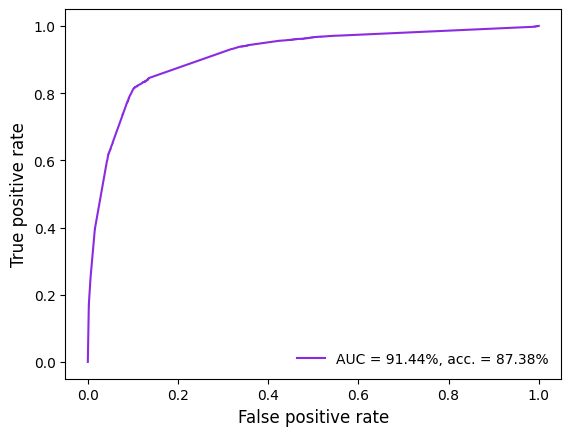

In [51]:
roc_c = plot_roc(y_test_filtered, preds_nn_c)
plt.close()

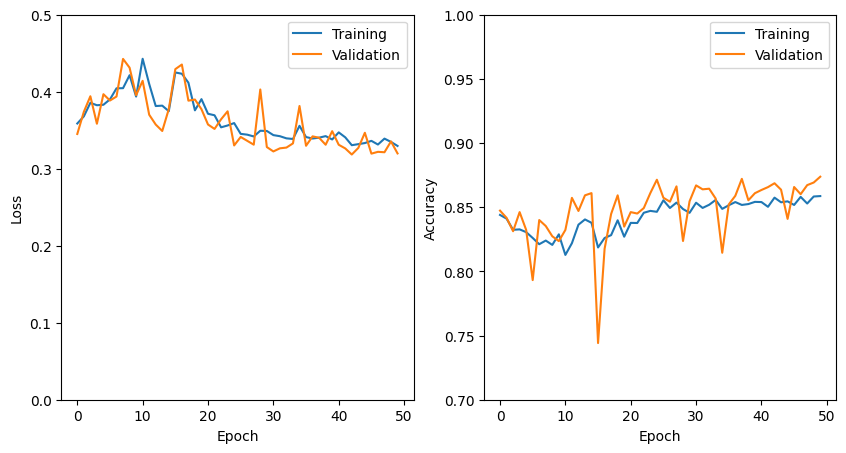

In [52]:
plot_model_history(history_c)

This is not too bad but not good either, with an AUC of 91.44% and accuracy of 87.38. Less than the BDT. 

We see the loss and accuracy are not really improving over time. This is because tanh works best when the values are around 0 with a standard deviation of 1. Higher values >> 1 or << 1 get mapped to ~1 so the activation cannot act on the values as well and the gradient dissappears.

## Problem D
Swap out the tanh activations for ReLU activations, while keeping everything else
the same. Does the network train effectively? Why or why not?

In [53]:
inputs = Input(shape=(X_train_filtered.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model_d = Model(inputs=inputs, outputs=outputs)

model_d.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history_d = model_d.fit(X_train_filtered, y_train_filtered, epochs=50, batch_size=128, validation_data=(X_test_filtered, y_test_filtered),verbose=0)

# retrieve predictions
preds_nn_d = model_d.predict(X_test_filtered, verbose=0)

Numerical instability / overflow on the first weight update: unscaled large positive inputs + ReLU produce very large activations whihc gives huge gradients/weight updates -> Inf/NaN in logits or loss. Sometimes when running the cell above I get nan for loss and it breaks for this reason. 

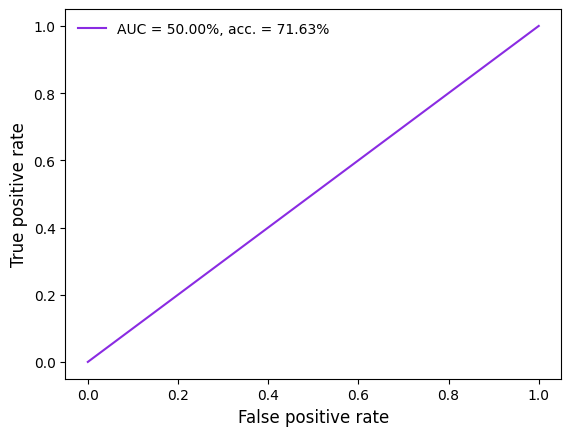

In [54]:
roc_d = plot_roc(y_test_filtered, preds_nn_d)
plt.close()

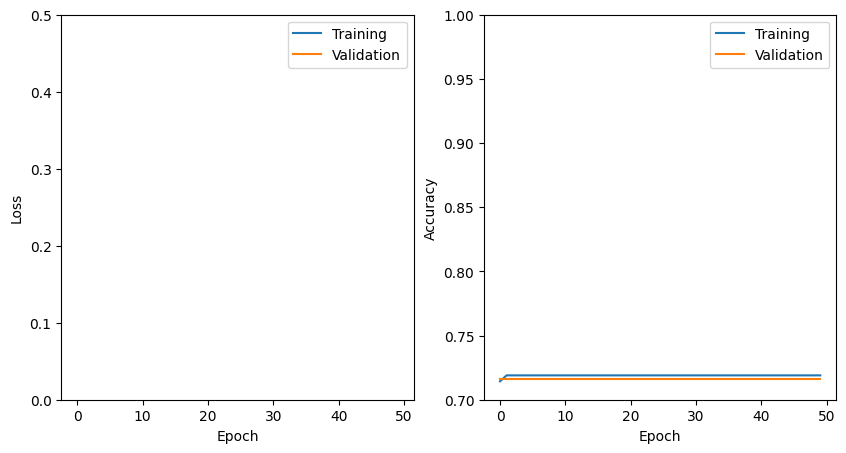

In [55]:
plot_model_history(history_d)

This is horrible, it's 50% - %50, so completely randomly guessing. The loss is high (sorry it's clipped), so probably weights are exploding or going to zero (dying neurons).

In [82]:
# compute % of positive values in X_train_filtered
pos_mask = X_train_filtered > 0
overall_pct = pos_mask.mean() * 100
per_feature_pct = pos_mask.mean(axis=0) * 100

print("Overall positivty: " ,overall_pct)
print("Features >90% positive:", np.where(per_feature_pct > 90)[0])
print("Features <10% positive:", np.where(per_feature_pct < 10)[0])

Overall positivty:  87.89320472630817
Features >90% positive: [ 0  1  2  3  6  7  8  9 10 11 13 14 15 16 17 18 19 21 22 23 24 26 27 28
 30 31 32 33 34 35 38 39 40 43 45 47 49]
Features <10% positive: [37]


For the features most values are already positive (x > 0) so ReLU (max(0, x)) acts like a linear model.

## Problem E
Now, we will make two minor changes to the network with ReLU activations:
preprocessing and the optimizer.
For the feature preprocessing use sklearn.preprocessing.StandardScaler to standardize the input
features. Note you should ﬁt the standard scaler to the training data only and apply it to both the training
and testing data. For the optimizer, use Adam with a learning rate of 0.001 (which is the default) instead of
SGD. Train the model for 50 epochs

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

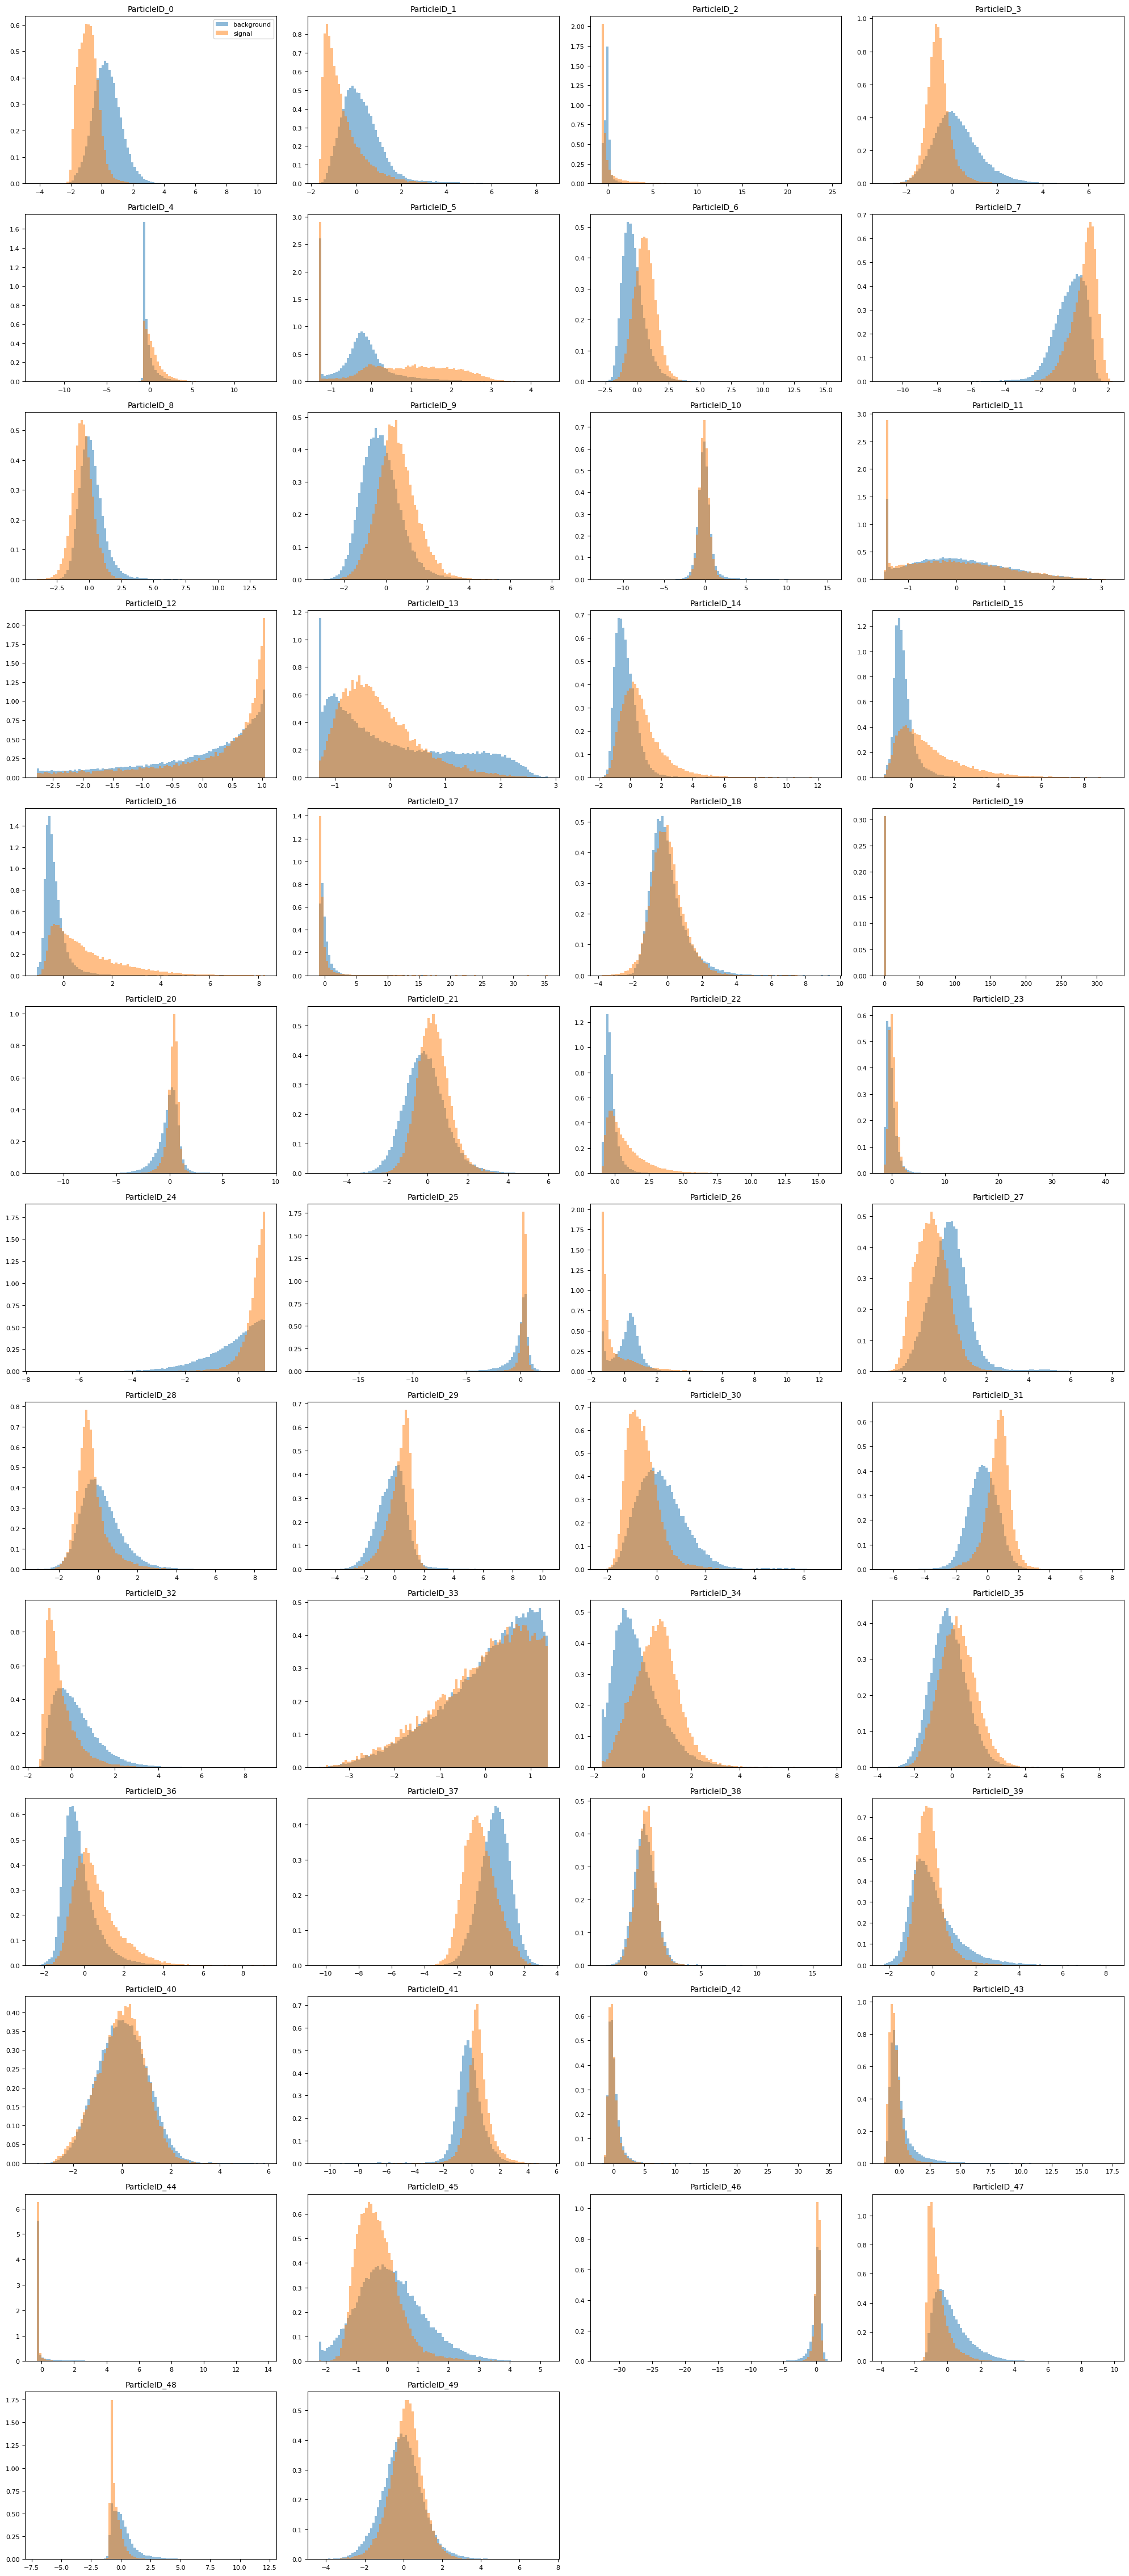

In [84]:
fig = plot_feature_distributions(X_train_scaled, y_train_filtered, feature_names)
plt.show()

In [85]:
for feature_idx in range(X_train_scaled.shape[1]):
	if feature_idx <10 or feature_idx >40:
		train_min = np.min(X_train_scaled[:, feature_idx])
		train_max = np.max(X_train_scaled[:, feature_idx])
		test_min = np.min(X_test_scaled[:, feature_idx])
		test_max = np.max(X_test_scaled[:, feature_idx])
		print(
			f"Feature {feature_idx:2d} | "
			f"train_scaled[min,max]=({train_min:.6g}, {train_max:.6g}) | "
			f"test_scaled[min,max]=({test_min:.6g}, {test_max:.6g})"
		)

Feature  0 | train_scaled[min,max]=(-4.18872, 10.4987) | test_scaled[min,max]=(-4.18872, 9.64031)
Feature  1 | train_scaled[min,max]=(-1.65225, 8.49562) | test_scaled[min,max]=(-1.6651, 7.17405)
Feature  2 | train_scaled[min,max]=(-0.687905, 24.7797) | test_scaled[min,max]=(-0.687761, 22.1983)
Feature  3 | train_scaled[min,max]=(-2.99522, 7.06401) | test_scaled[min,max]=(-2.91417, 7.61163)
Feature  4 | train_scaled[min,max]=(-13.2572, 13.6022) | test_scaled[min,max]=(-11.7174, 13.2533)
Feature  5 | train_scaled[min,max]=(-1.30515, 4.41768) | test_scaled[min,max]=(-1.30515, 3.6096)
Feature  6 | train_scaled[min,max]=(-2.82584, 15.3475) | test_scaled[min,max]=(-2.82584, 10.5805)
Feature  7 | train_scaled[min,max]=(-11.1038, 2.25953) | test_scaled[min,max]=(-11.2234, 2.35513)
Feature  8 | train_scaled[min,max]=(-4.07694, 13.6915) | test_scaled[min,max]=(-4.16267, 14.3793)
Feature  9 | train_scaled[min,max]=(-3.21021, 7.801) | test_scaled[min,max]=(-2.93826, 8.02441)
Feature 41 | train_sca

From the plots and the min, max values we see clearly now the features have data points in the negative range as well, so ReLU can act better on it in a non-linear way.

In [86]:
inputs = Input(shape=X_train_scaled.shape[1:])
outputs = Dense(128, activation='relu')(inputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)
model_e = Model(inputs=inputs, outputs=outputs)

model_e.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_e = model_e.fit(X_train_scaled, y_train_filtered, epochs=50, batch_size=128, validation_data=(X_test_scaled, y_test_filtered), verbose=0)

preds_nn_e = model_e.predict(X_test_scaled, verbose=0)

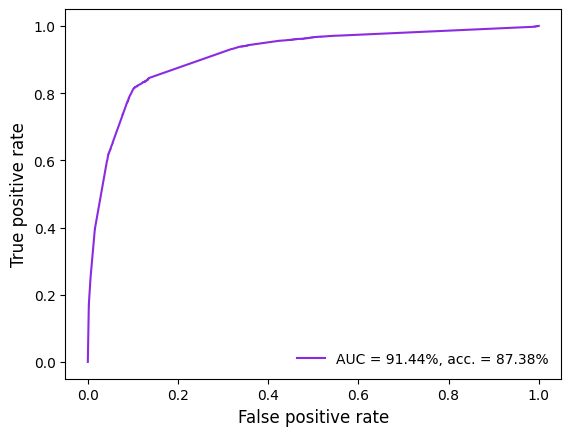

In [90]:
# orginal plot
roc_c

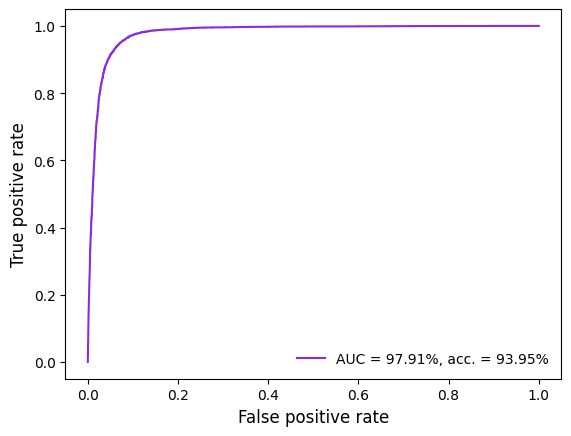

In [91]:
roc_e = plot_roc(y_test_filtered, preds_nn_e)
plt.close()

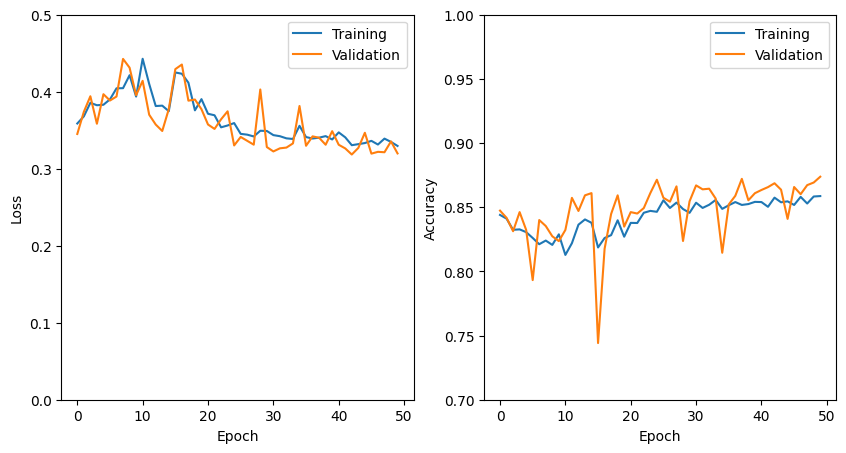

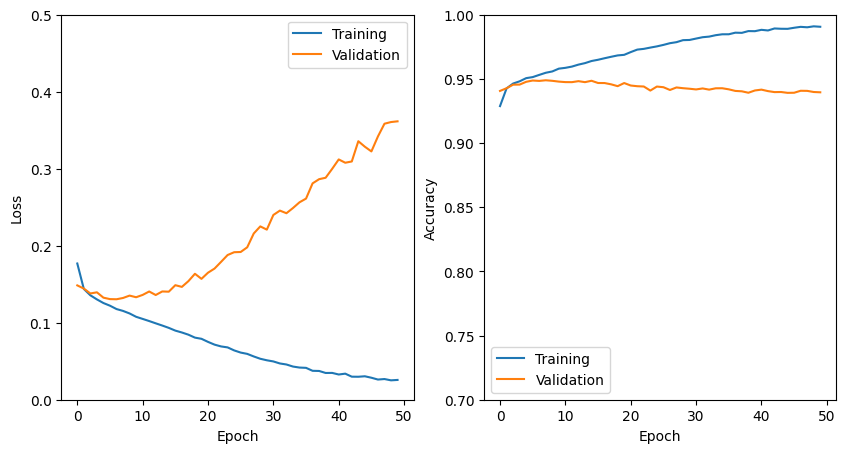

In [92]:
plot_model_history(history_c)
plot_model_history(history_e)

We see it has a very nice, smooth, roc curve now. It performs around 6-9% better than the out of the box NN version. The scaled NN AUC closesly resembles the BDT version, only slightly (0.5%) worse.

The loss and accuracy curves are also smoother. There does appear to be some overfitting? There is a big gap between training and test loss (but the test loss is comparable to C), and a 5% gap between training and test accuracy.

# Optional refinements

Add further refinements to the neural network in the last step of the previous exercise. Try and get the classification as good as you can. For example, consider batchnorm, layer initialization, dropout, wider/deeper nets, .... . If you can't find a significant improvement, just show the code and report on the result of a few experiments (I tried X because I thought/saw Y, result was Z).

Let's first manipulate our data so that ReLU can work with it even better!

In [94]:
# this was suggested to me by ChatGPT I did not come up with this myself
# my first try was removing outliers based on percentile but then 40% of the training data was removed, ouch

qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
X_train_transformed = qt.fit_transform(X_train_filtered)
X_test_transformed = qt.transform(X_test_filtered)

In [95]:
# print all min and max values for each feature of X
for feature_idx in range(X_train_transformed.shape[1]):
	if feature_idx <5 or feature_idx >45:
		train_min = np.min(X_train_transformed[:, feature_idx])
		train_max = np.max(X_train_transformed[:, feature_idx])
		test_min = np.min(X_test_transformed[:, feature_idx])
		test_max = np.max(X_test_transformed[:, feature_idx])
		print(
			f"Feature {feature_idx:2d} | "
			f"train_scaled[min,max]=({train_min:.6g}, {train_max:.6g}) | "
			f"test_scaled[min,max]=({test_min:.6g}, {test_max:.6g})"
		)

Feature  0 | train_scaled[min,max]=(-5.19934, 5.19934) | test_scaled[min,max]=(-5.19934, 5.19934)
Feature  1 | train_scaled[min,max]=(-5.19934, 5.19934) | test_scaled[min,max]=(-5.19934, 3.353)
Feature  2 | train_scaled[min,max]=(-5.19934, 5.19934) | test_scaled[min,max]=(-5.19934, 5.19934)
Feature  3 | train_scaled[min,max]=(-5.19934, 5.19934) | test_scaled[min,max]=(-5.19934, 5.19934)
Feature  4 | train_scaled[min,max]=(-5.19934, 5.19934) | test_scaled[min,max]=(-5.19934, 5.19934)
Feature 46 | train_scaled[min,max]=(-5.19934, 5.19934) | test_scaled[min,max]=(-5.19934, 5.19934)
Feature 47 | train_scaled[min,max]=(-5.19934, 5.19934) | test_scaled[min,max]=(-5.19934, 3.31833)
Feature 48 | train_scaled[min,max]=(-5.19934, 5.19934) | test_scaled[min,max]=(-5.19934, 5.19934)
Feature 49 | train_scaled[min,max]=(-5.19934, 5.19934) | test_scaled[min,max]=(-5.19934, 5.19934)


Basically every feature looks the same.

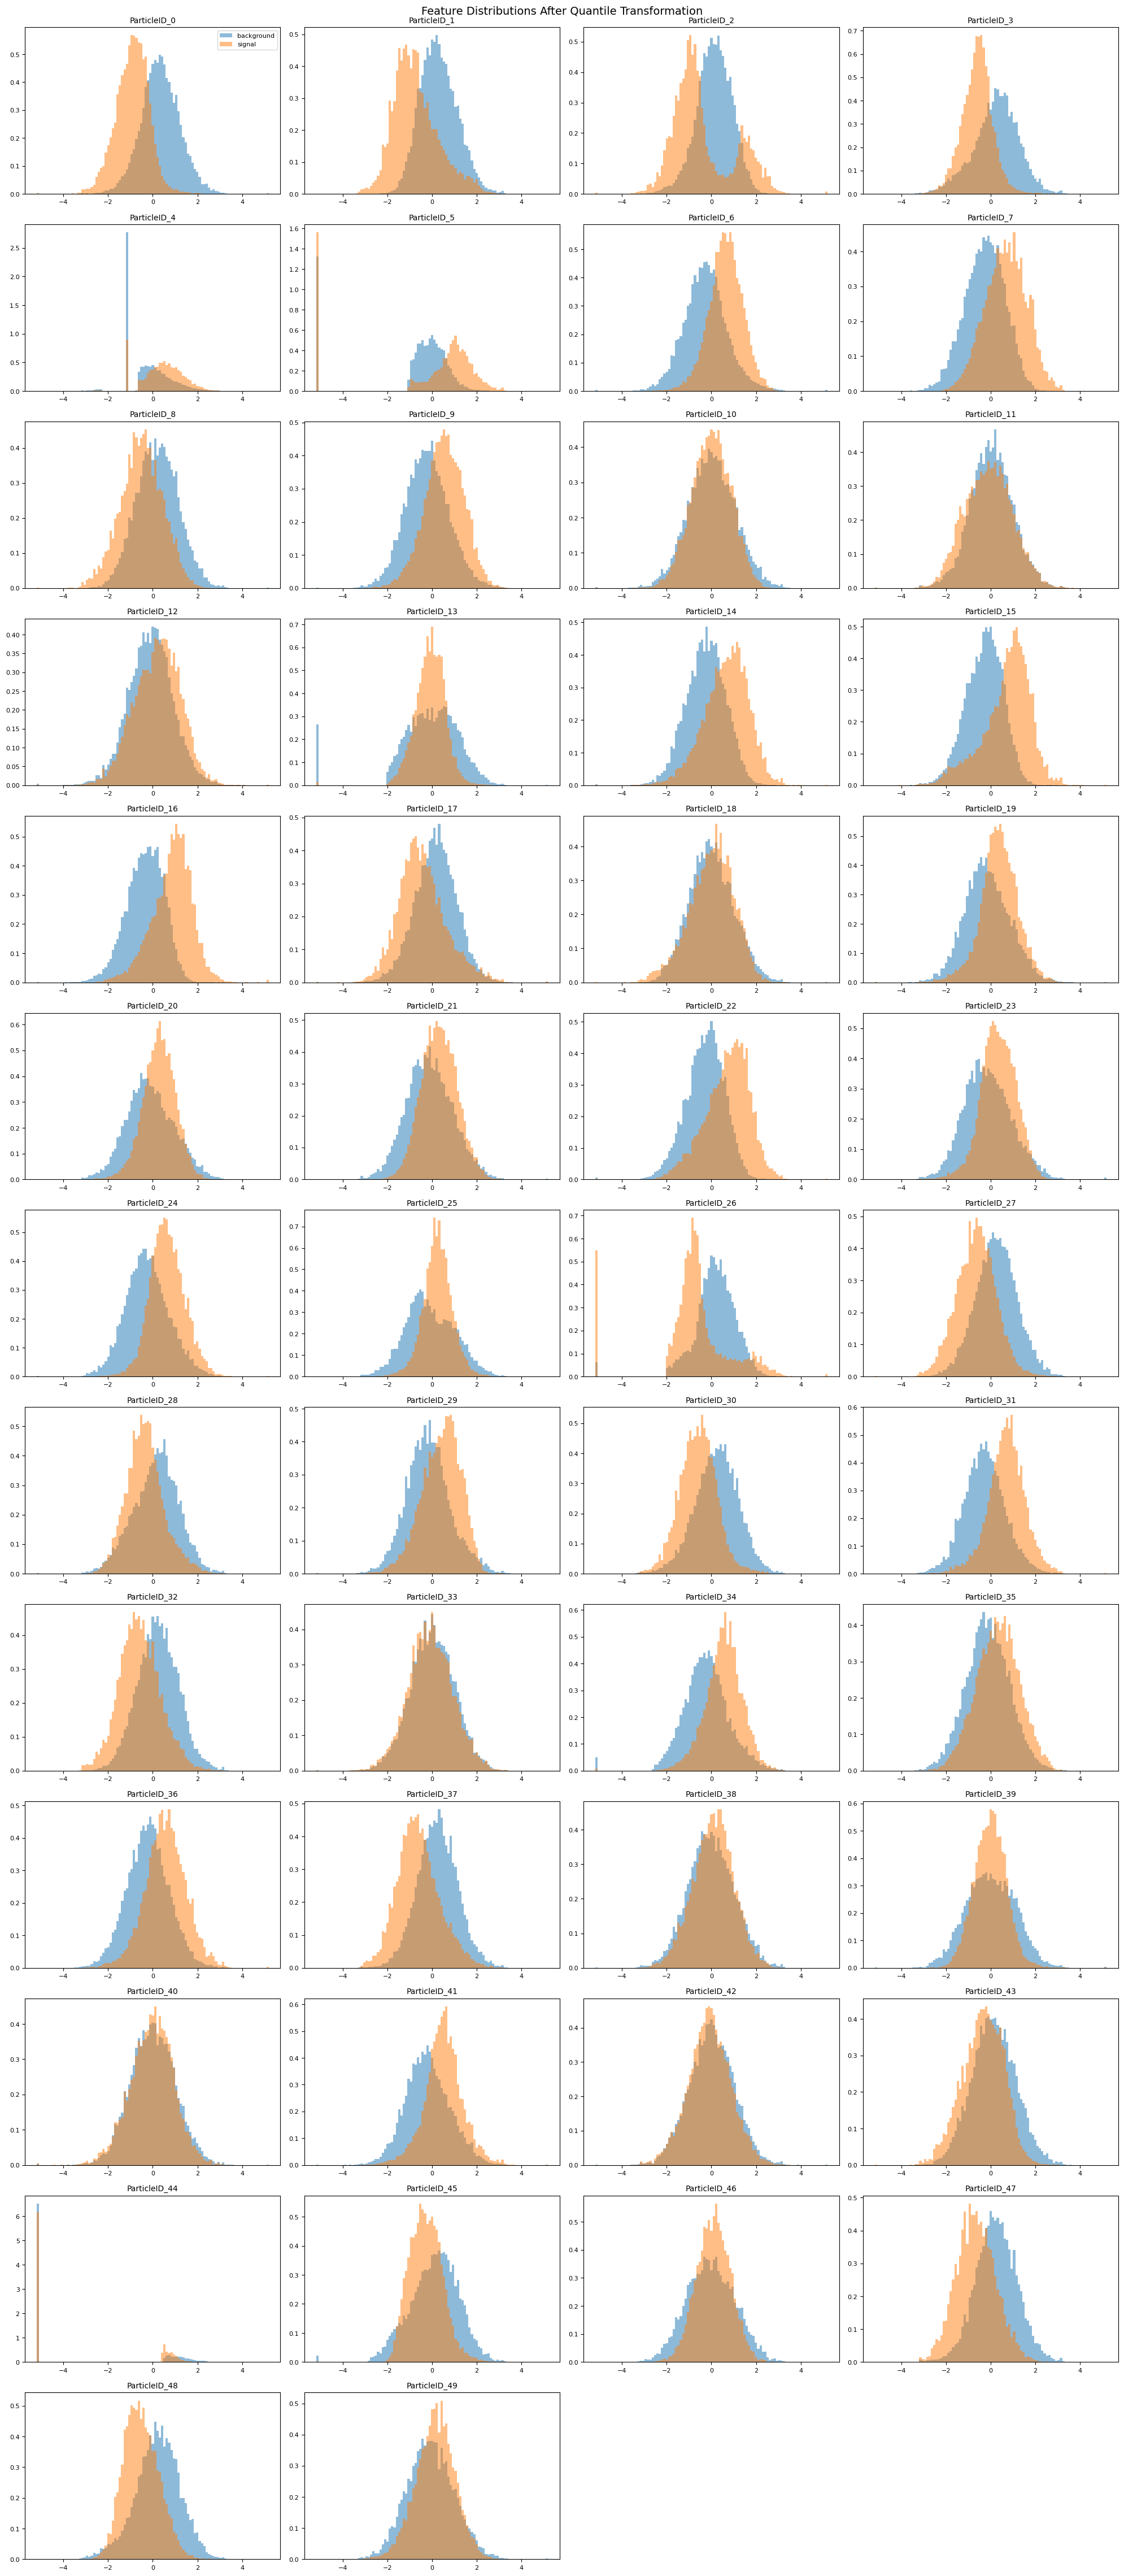

In [96]:
# Visualize the transformed features
fig = plot_feature_distributions(X_train_transformed, y_train_filtered, feature_names)
plt.suptitle('Feature Distributions After Quantile Transformation', fontsize=14, y=1.001)
plt.show()

Adam automatically adjusts the learning rate for us, so we keep that. Now we can apply other things as well.

In [97]:
def run_experiment(hidden_layers, use_batchnorm=False, dropout_rate=0.0, kernel_initializer='glorot_uniform'):

    inputs = Input(shape=(X_train_transformed.shape[1],))

    x = inputs
    for units in hidden_layers:
        x = Dense(units, activation='relu', kernel_initializer=kernel_initializer)(x)
        if use_batchnorm:
            x = BatchNormalization()(x)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_transformed, y_train_filtered, epochs=50, batch_size=128, validation_data=(X_test_transformed, y_test_filtered), verbose=0)

    preds = model.predict(X_test_transformed, verbose=0)

    auc = roc_auc_score(y_test_filtered, preds)

    roc_plot = plot_roc(y_test_filtered, preds)
    
    return model, history, auc, roc_plot

### Experiment 0: Transformed with Quantile

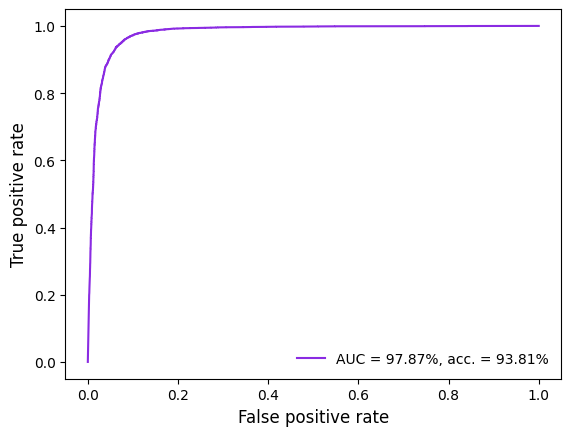

In [98]:
model_qu, history_qu, auc_qu, roc_plot_qu = run_experiment(
    hidden_layers=[128, 128, 128],
    use_batchnorm=False,
    dropout_rate=0.0,
    kernel_initializer=GlorotUniform()
)

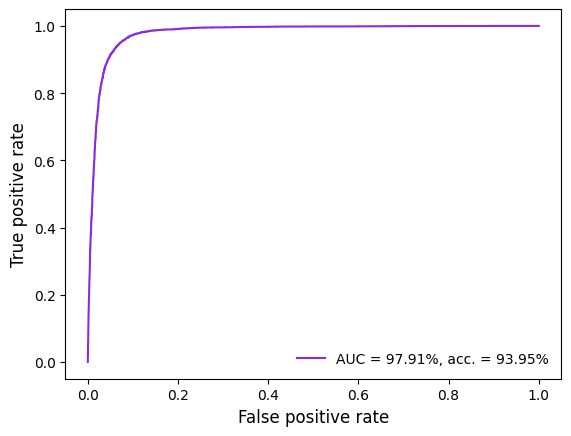

In [99]:
roc_e

Does not appear to help, but as the difference is neglible and I'm too lazy too change the run_experiment function we will keep it.

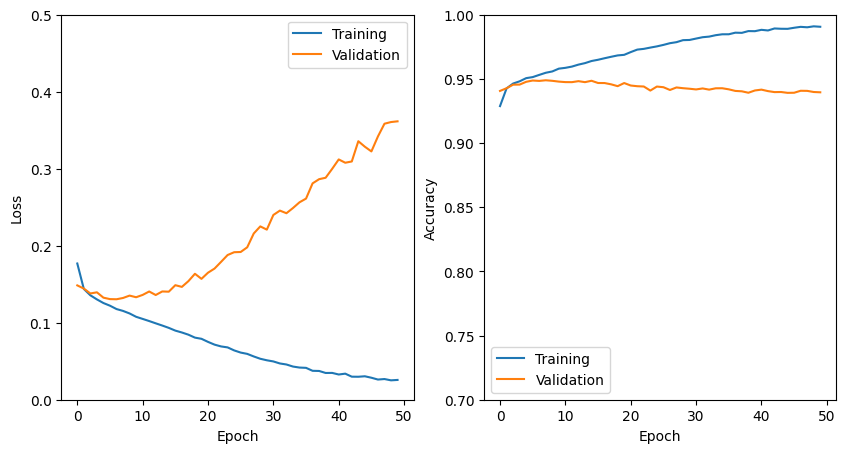

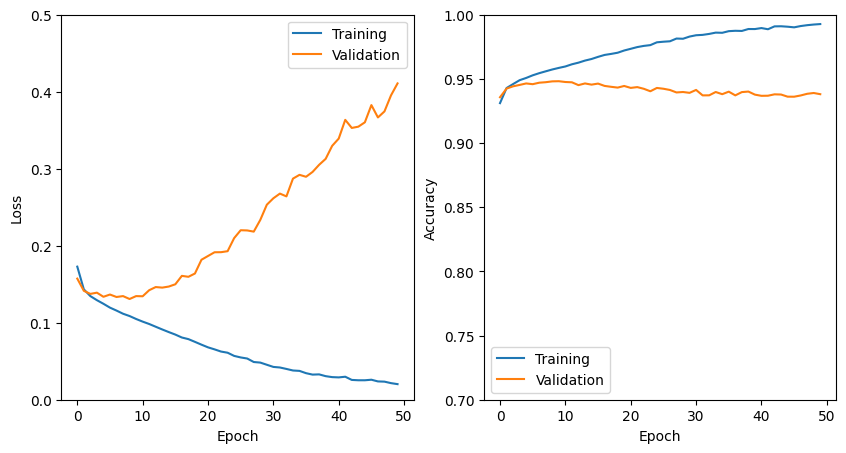

In [100]:
plot_model_history(history_e)
plot_model_history(history_qu)

### Experiment 1: Batch Normalization

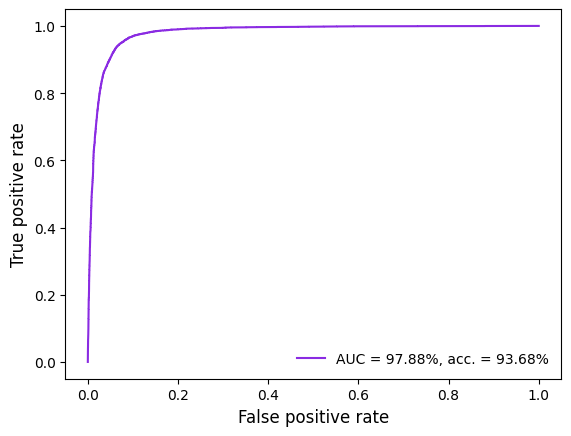

In [101]:
model_bn, history_bn, auc_bn, roc_plot_bn = run_experiment(
    hidden_layers=[128, 128, 128],
    use_batchnorm=True,
    dropout_rate=0.0,
    kernel_initializer=GlorotUniform()
)

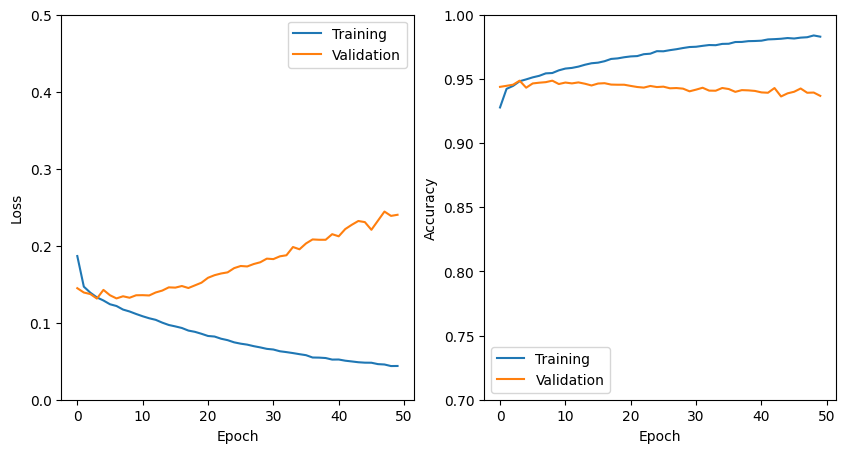

In [102]:
plot_model_history(history_bn)

Is a bit better than the scaled version and pretty close to the BDT.

### Experiment 2: Dropout

This would have the most promising results because people are doing this a lot. And if people are doing it, then it must be useful.

In [ ]:
model_do, history_do, auc_do, roc_plot_do = run_experiment(
    hidden_layers=[128, 128, 128],
    use_batchnorm=False,
    dropout_rate=0.2,
    kernel_initializer=GlorotUniform()
)

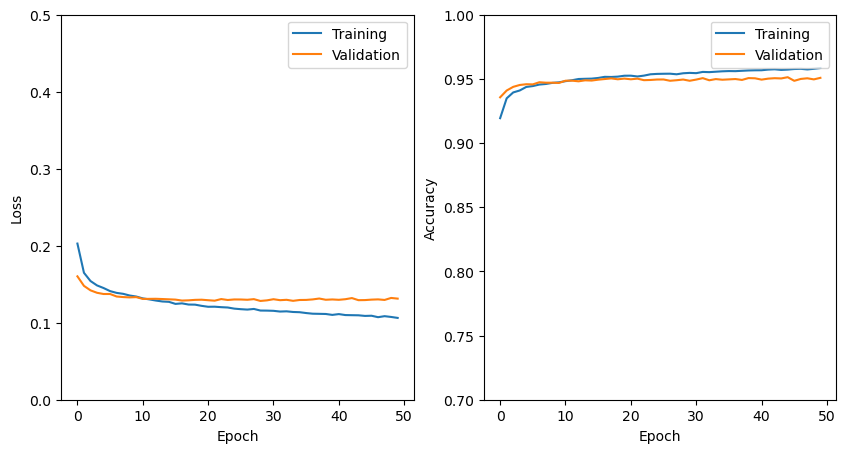

In [ ]:
plot_model_history(history_do)

Outperforms the BDT! And there is no overfitting.

### Experiment 3: Layer Initialization (He Normal)

ReLU zeros about half the activations, He normal prevents signal shrinking. 

811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC: 0.976757


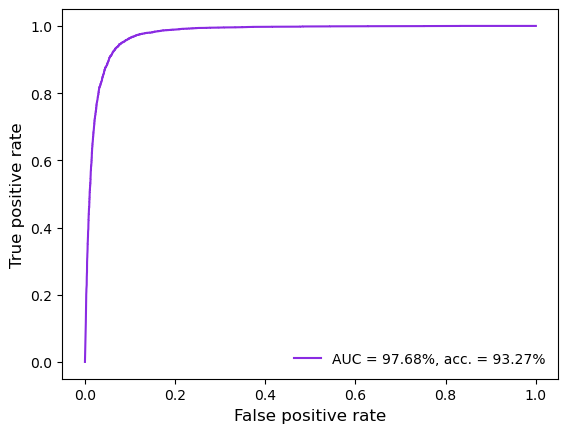

In [ ]:
model_he, history_he, auc_he, roc_plot_he = run_experiment(
    hidden_layers=[128, 128, 128],
    use_batchnorm=False,
    dropout_rate=0.0,
    kernel_initializer=HeNormal()
)

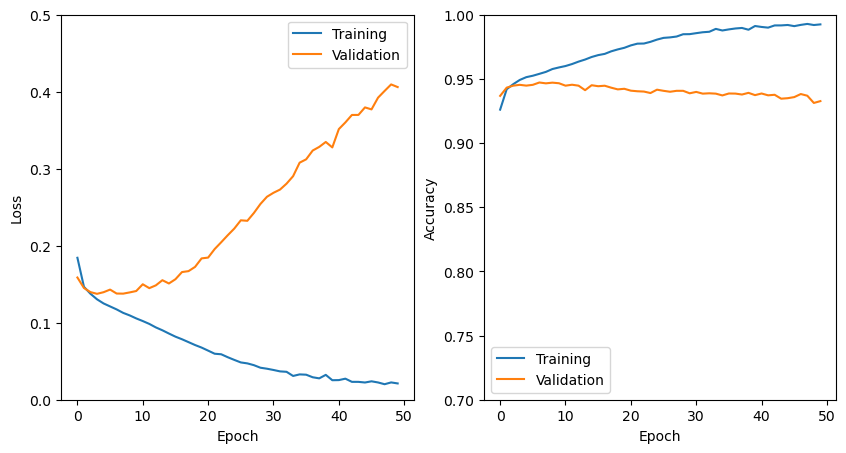

In [ ]:
plot_model_history(history_he)

Does not appear to do much.

### Experiment 4: Wider and Deeper Networks

Wider

811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC: 0.980305


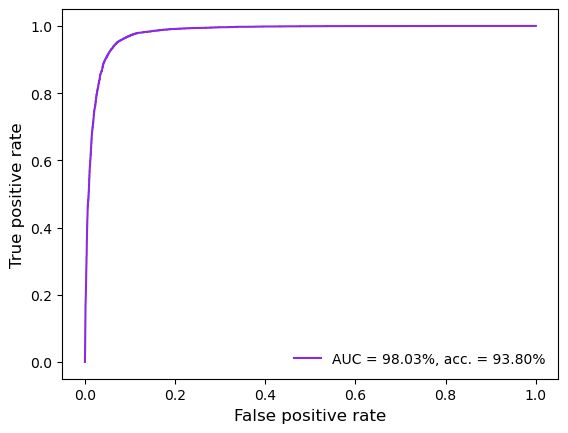

In [ ]:
model_wide, history_wide, auc_wide, roc_plot_wide = run_experiment(
    hidden_layers=[256, 256, 128],
    use_batchnorm=False,
    dropout_rate=0.0,
    kernel_initializer=GlorotUniform()
)

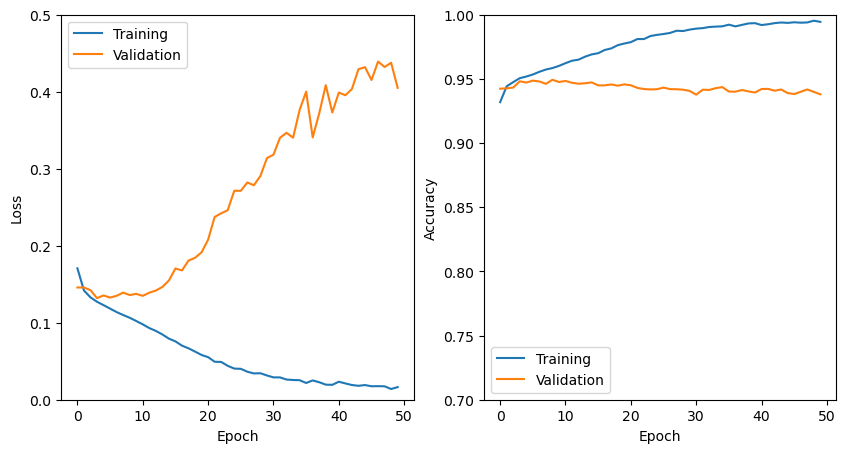

In [ ]:
plot_model_history(history_wide)

Enormous overfitting, if I may say so. But quite good accuracy

deeper

811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC: 0.979680


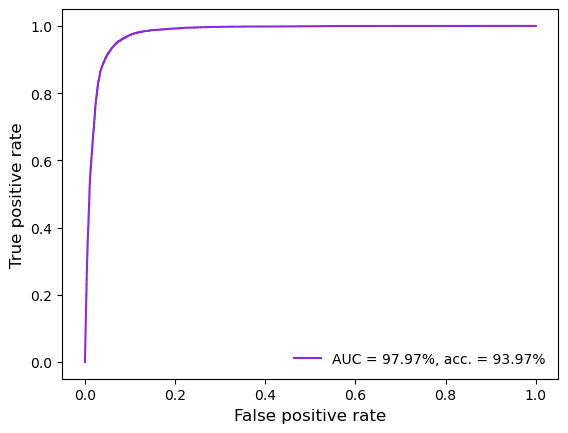

In [ ]:
model_deep, history_deep, auc_deep, roc_plot_deep = run_experiment(
    hidden_layers=[128, 128, 128, 64, 64],
    use_batchnorm=False,
    dropout_rate=0.0,
    kernel_initializer=GlorotUniform()
)

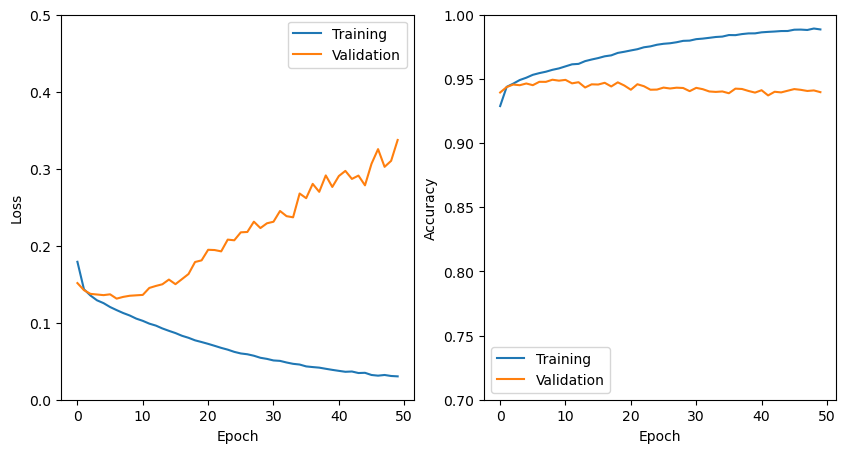

In [ ]:
plot_model_history(history_deep)

### Experiment 5: Replicating a paper

To get a classification as good as possible, why not just copy someone elses work!

Although they use a different filter/scaler for processing the features, i will use the same architecture

https://arxiv.org/pdf/2104.14045

- Hidden layers: 256 -> 128 -? 128-> 64 nodes
- Activation: ELU
- Dropout: 0.2 on first 3 hidden layers
- Output: sigmoid
- Loss: Binary Crossentropy
- Optimizer: Adam

811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Paper Architecture AUC: 0.987984


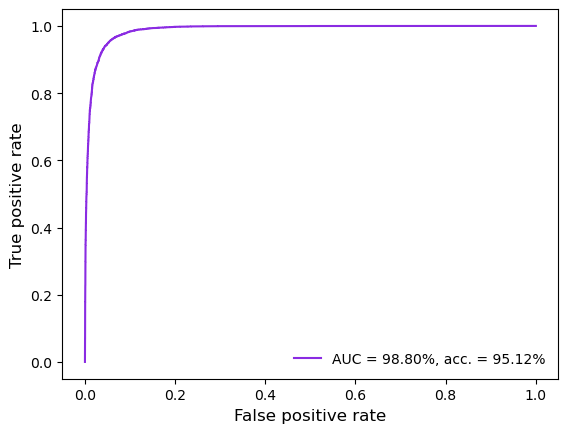

In [ ]:
inputs_paper = Input(shape=(X_train_transformed.shape[1],))

x_paper = Dense(256, activation='elu')(inputs_paper)
x_paper = Dropout(0.2)(x_paper)
x_paper = Dense(128, activation='elu')(x_paper)
x_paper = Dropout(0.2)(x_paper)
x_paper = Dense(128, activation='elu')(x_paper)
x_paper = Dropout(0.2)(x_paper)
x_paper = Dense(64, activation='elu')(x_paper)
outputs_paper = Dense(1, activation='sigmoid')(x_paper)

model_paper = Model(inputs=inputs_paper, outputs=outputs_paper)

# Compile with Binary Crossentropy and Adam
model_paper.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_paper = model_paper.fit(X_train_transformed, y_train_filtered, epochs=50, batch_size=128, validation_data=(X_test_transformed, y_test_filtered), verbose=0)

# Get predictions and compute AUC
preds_paper = model_paper.predict(X_test_transformed)
auc_paper = roc_auc_score(y_test_filtered, preds_paper)

print(f"Paper Architecture AUC: {auc_paper:.6f}")
roc_plot_paper = plot_roc(y_test_filtered, preds_paper)
plt.show()

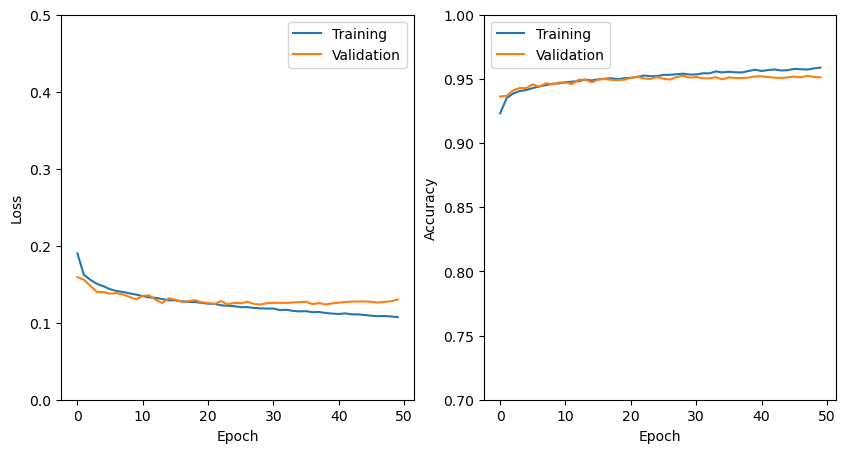

In [ ]:
plot_model_history(history_paper)

### Compare Optional Experiments

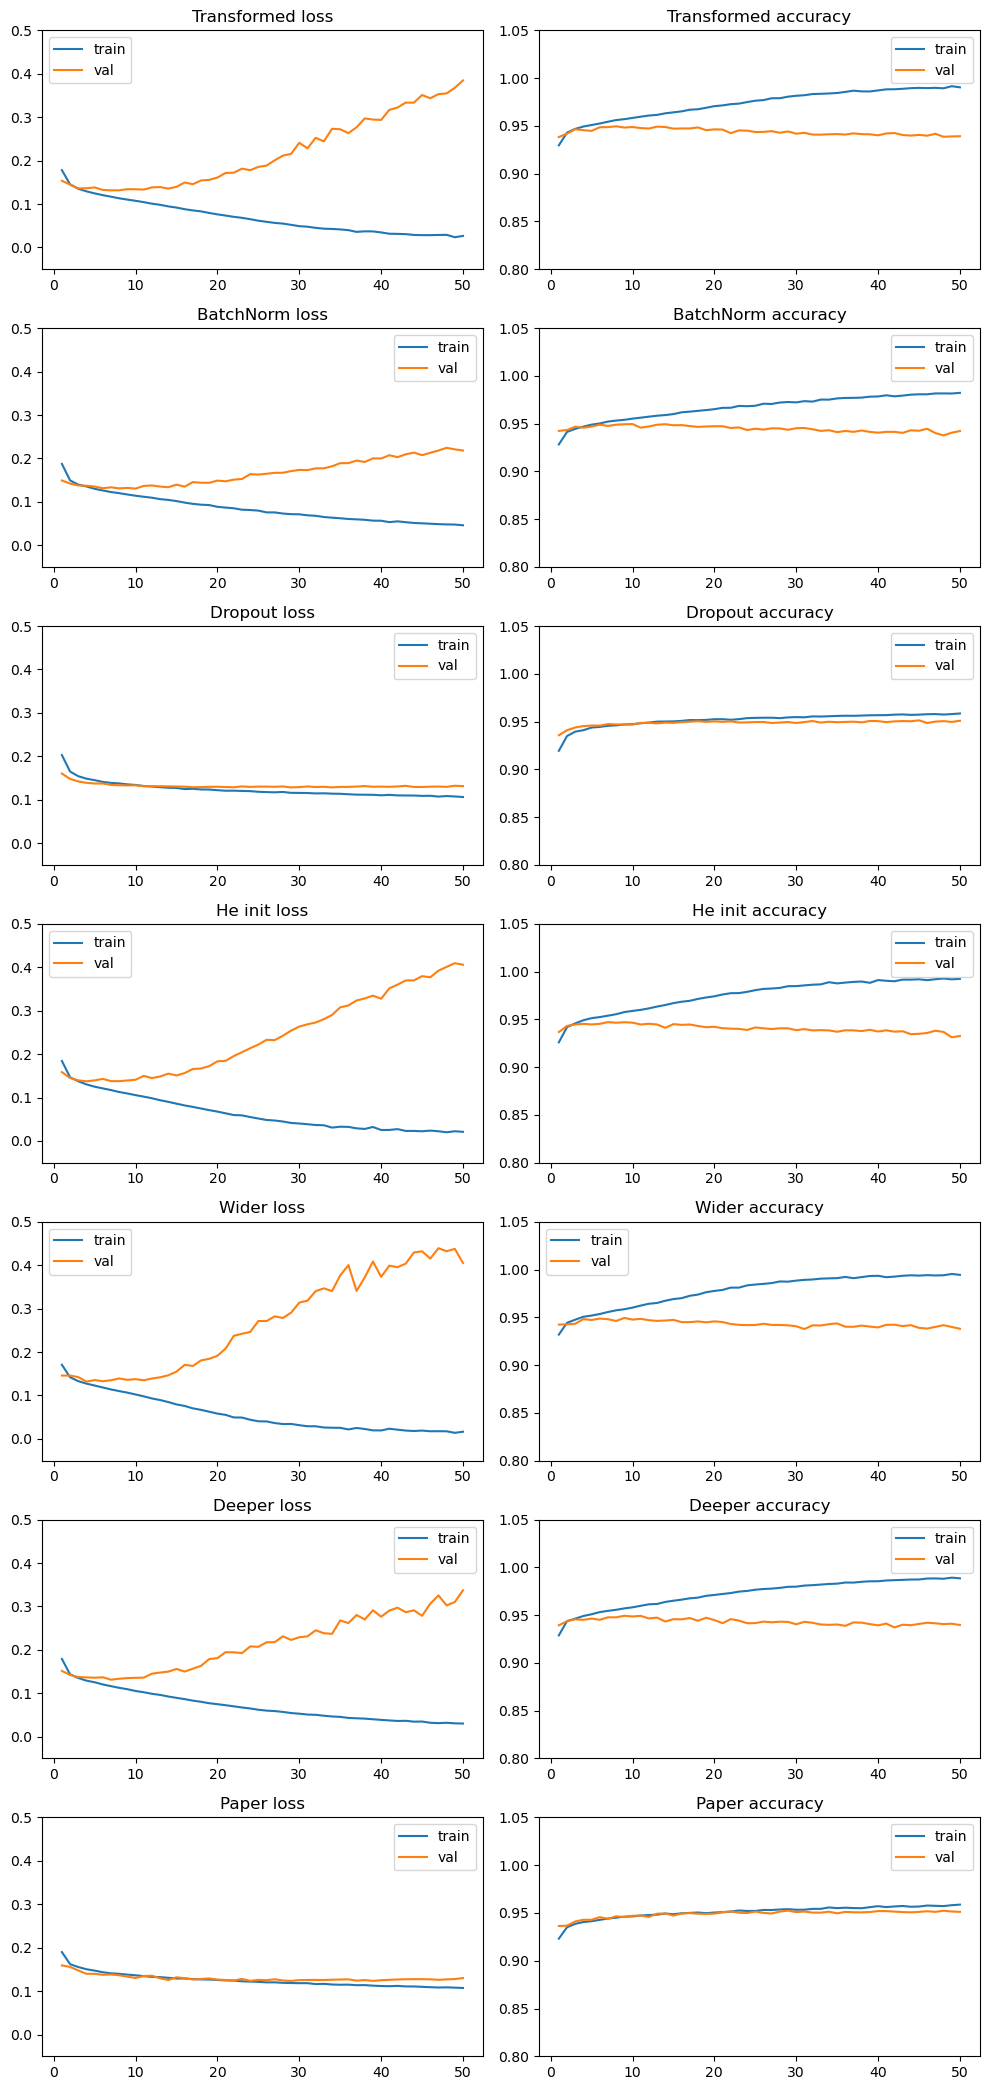

Train AUC  |  Test AUC  |  Gap   | Model
0.9523    0.9453    0.0070   Transformed
0.9272    0.9176    0.0096   BatchNorm
0.9626    0.9598    0.0029   Dropout
0.9263    0.9193    0.0069   He init
0.9386    0.9303    0.0083   Wider
0.9607    0.9558    0.0049   Deeper
0.9940    0.9880    0.0060   Paper


In [ ]:
models = [
    ("Transformed",model_qu, history_qu),
    ("BatchNorm", model_bn, history_bn),
    ("Dropout", model_do, history_do),
    ("He init", model_he, history_he),
    ("Wider", model_wide, history_wide),
    ("Deeper", model_deep, history_deep),
    ("Paper", model_paper, history_paper)
]

# Plot train/val loss and accuracy for each experiment
fig, axes = plt.subplots(len(models), 2, figsize=(10, 3 * len(models)))
for i, (name, m, h) in enumerate(models):
    ep = range(1, len(h.history["loss"]) + 1)
    axes[i, 0].plot(ep, h.history["loss"], label="train")
    axes[i, 0].plot(ep, h.history["val_loss"], label="val")
    axes[i, 0].set_ylim(-0.05,0.5)
    axes[i, 0].set_title(f"{name} loss"); axes[i, 0].legend()

    axes[i, 1].plot(ep, h.history["accuracy"], label="train")
    axes[i, 1].plot(ep, h.history["val_accuracy"], label="val")
    axes[i, 1].set_ylim(0.8, 1.05)
    axes[i, 1].set_title(f"{name} accuracy"); axes[i, 1].legend()

plt.tight_layout()
plt.show()

print("Train AUC  |  Test AUC  |  Gap   | Model")
for name, m, h in models:
    preds_train = m.predict(X_train_transformed, verbose=0)
    preds_test  = m.predict(X_test_transformed, verbose=0)
    auc_train = roc_auc_score(y_train_filtered, preds_train)
    auc_test  = roc_auc_score(y_test_filtered,  preds_test)
    print(f"{auc_train:.4f}    {auc_test:.4f}    {auc_train-auc_test:.4f}   {name}")

Sorted by Test AUC (best to worst):

Paper

Dropout

Deeper

Transformed

He init

BatchNorm

Wider

Surprise surprise, the paper is the best, boring.

Interestingly, in the paper they get a 0.952 in accuracy and I have a 0.951, pretty close I might say.

From the paper: "We train with a learning rate of 0.001 for 45 epochs, starting at a
batch size of 32 and doubling it every 5 epochs, ending at a batch size of 8192. We then train for
an additional 50 epochs at batch size 8192 with decaying learning rate to fine tune the weights
around the found minimum."

Which is something that I did not investigate as I did not set up my GPU environment yet.